In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Preparing Data

In [4]:
# read data
data = pd.read_excel(r'/content/drive/MyDrive/TA (1)/Processing Data/Data/raw data/data_after_cleansing.xlsx',sheet_name="Belawan")
data

,Date,Hours,Hs [m],Angin [m/s]
0,1999-07-10 15:00:00,1,0.750,2.726197
1,1999-07-10 16:00:00,2,0.750,2.608670
2,1999-07-10 17:00:00,3,0.750,3.021065
3,1999-07-10 18:00:00,4,0.688,3.464277
4,1999-07-10 19:00:00,5,0.688,3.940771
...,...,...,...,...
437,1999-07-28 20:00:00,438,0.656,2.244146
438,1999-07-28 21:00:00,439,0.500,1.601026
439,1999-07-28 22:00:00,440,0.500,1.483258
440,1999-07-28 23:00:00,441,0.500,1.312014


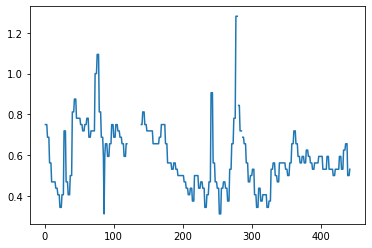

In [5]:
# plotting raw data
plt.plot(data['Hours'],data['Hs [m]'])
plt.show()

In [6]:
import copy
data_raw = copy.deepcopy(data)

### Interpolation

In [7]:
# import library
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline

In [8]:
# define other dataframe for interpolate 
data2 = copy.deepcopy(data)
data3 = copy.deepcopy(data)
data4 = copy.deepcopy(data)

In [9]:
# drop NaN value in dataframe data
data = data.dropna()

In [10]:
# cubic interpolation
y_fc=interp1d(data['Hours'],data['Hs [m]'], kind='cubic')

In [11]:
# quadratic interpolation
y_fq=interp1d(data['Hours'],data['Hs [m]'], kind='quadratic')

In [12]:
y_fc=CubicSpline(data['Hours'],data['Hs [m]'],extrapolate=True)

In [13]:
# linear interpolation
y_fl=interp1d(data['Hours'],data['Hs [m]'], kind='linear')

In [14]:
# interpolate using function we define before
import math

for i in data2['Hours'] :
  if math.isnan(data2['Hs [m]'][i-1])== True:
    data2['Hs [m]'][i-1] = y_fc(i)
    data3['Hs [m]'][i-1] = y_fq(i)
    data4['Hs [m]'][i-1] = y_fl(i)
  else:
    pass
#data.loc[data['Hs [m]'].isna()]

<ipython-input-14-86623d2f7eed>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['Hs [m]'][i-1] = y_fc(i)
<ipython-input-14-86623d2f7eed>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['Hs [m]'][i-1] = y_fq(i)
<ipython-input-14-86623d2f7eed>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data4['Hs [m]'][i-1] = y_fl(i)


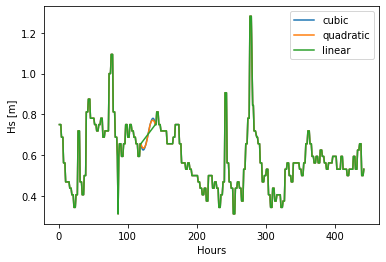

In [15]:
# plot after interpolation
plt.plot(data2['Hours'],data2['Hs [m]'], label ='cubic')
plt.plot(data3['Hours'],data3['Hs [m]'], label ='quadratic')
plt.plot(data4['Hours'],data4['Hs [m]'], label ='linear')
#plotting scatter point of data
plt.xlabel('Hours')
plt.ylabel('Hs [m]')
plt.legend()
plt.show()

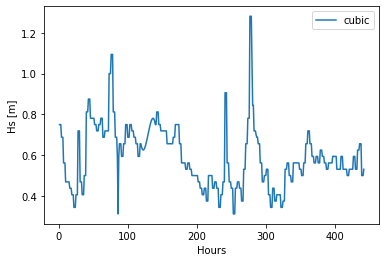

In [16]:
# plot after interpolation
plt.plot(data2['Hours'],data2['Hs [m]'], label ='cubic')
#plotting scatter point of data
plt.xlabel('Hours')
plt.ylabel('Hs [m]')
plt.legend()
plt.show()

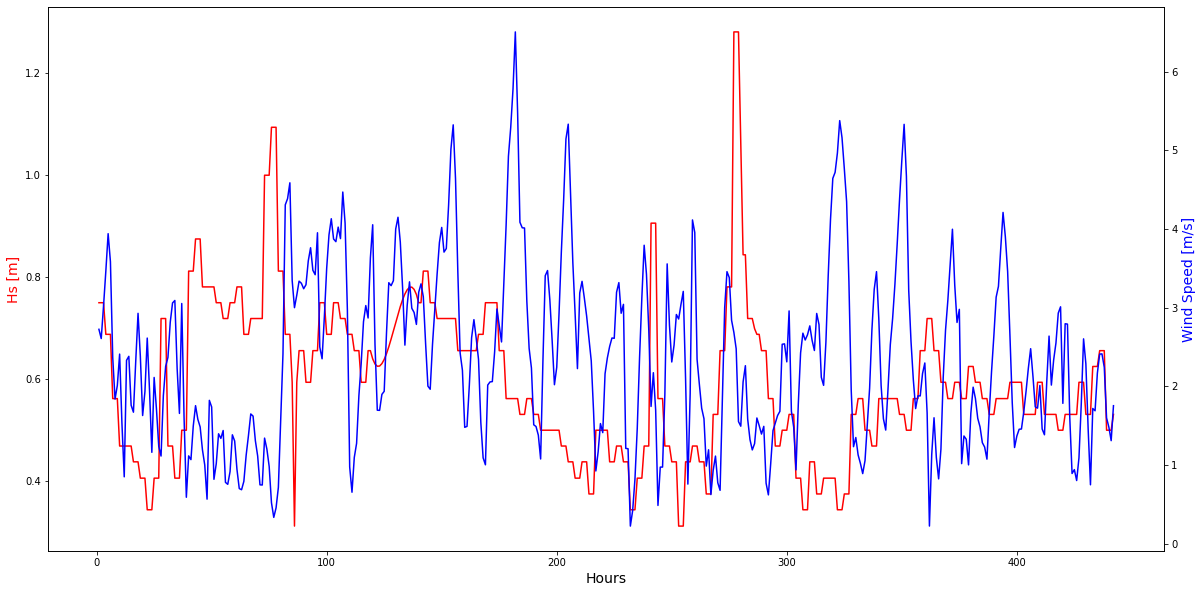

In [17]:
# plotting wind and wave
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(20, 10))
# make a plot
ax.plot(data2['Hours'],
        data2['Hs [m]'],
        color="red", 
        )
# set x-axis label
ax.set_xlabel("Hours", fontsize = 14)
# set y-axis label
ax.set_ylabel("Hs [m]",
              color="red",
              fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data2['Hours'],
        data2['Angin [m/s]'],color="blue")
ax2.set_ylabel("Wind Speed [m/s]",color="blue",fontsize=14)
plt.show()

karena data tidak berdistribusi normal -> ada skew nya (positif) makanya buat scaling data pake -> Normalize Data

## splitting data

In [18]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


values = data2.values
values = values[:,2:]
values

array([[0.75, 2.72619685446139],
       [0.75, 2.60866988764664],
       [0.75, 3.02106509959718],
       [0.688, 3.46427693377657],
       [0.688, 3.94077076784242],
       [0.688, 3.585189473803],
       [0.562, 2.36731524072135],
       [0.562, 1.84021990239815],
       [0.562, 2.01271199289343],
       [0.469, 2.41130350835543],
       [0.469, 1.5313577549368],
       [0.469, 0.852723859356236],
       [0.469, 2.33221924683064],
       [0.469, 2.38304041142915],
       [0.469, 1.76185906558065],
       [0.438, 1.67351217007421],
       [0.438, 2.32022064306438],
       [0.438, 2.92914937145177],
       [0.406, 2.3839862590012],
       [0.406, 1.63134592315005],
       [0.406, 1.93596109450304],
       [0.344, 2.6149229278262],
       [0.344, 1.94772748898511],
       [0.344, 1.16375205506291],
       [0.406, 2.11475147697223],
       [0.406, 1.71605978003174],
       [0.406, 1.2404785229162],
       [0.719, 1.11650732891196],
       [0.719, 1.88301697510929],
       [0.719, 2.25546

In [19]:
# ensure all data is float
values = values.astype('float32')

In [20]:
# normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)
# scaled 

In [21]:
# frame as supervised learning
reframed = series_to_supervised(values, 2, 1) #data, window width , output size
reframed.head()

,var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t),var2(t)
2,0.750,2.726197,0.750,2.608670,0.750,3.021065
3,0.750,2.608670,0.750,3.021065,0.688,3.464277
4,0.750,3.021065,0.688,3.464277,0.688,3.940771
5,0.688,3.464277,0.688,3.940771,0.688,3.585190
6,0.688,3.940771,0.688,3.585190,0.562,2.367315


In [22]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[-1], axis=1, inplace=True)
print(reframed.head())

   var1(t-2)  var2(t-2)  var1(t-1)  var2(t-1)  var1(t)
2      0.750   2.726197      0.750   2.608670    0.750
3      0.750   2.608670      0.750   3.021065    0.688
4      0.750   3.021065      0.688   3.464277    0.688
5      0.688   3.464277      0.688   3.940771    0.688
6      0.688   3.940771      0.688   3.585190    0.562


In [23]:
reframed.shape


(440, 5)

In [24]:
len(reframed)

440

In [25]:
values = reframed.values

In [26]:
# split into train and test sets
train = values[:round(len(reframed)*0.7), :]
val = values[round(len(reframed)*0.7) : round(len(reframed)*0.8) , :]
test = values[round(len(reframed)*0.8):, :]

In [27]:
n_hours = 2
n_features = 2
n_obs = n_hours * n_features
X_train1, y_train1 =train[:, :n_obs], train[:, -1]
X_val1, y_val1 = val[:, :n_obs], val[:, -1]
X_test1, y_test1 = test[:, :n_obs], test[:, -1]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((308, 4), (308,), (44, 4), (44,), (88, 4), (88,))

In [28]:
# reshape input to be 3D [samples, timesteps, features]
X_train1 = X_train1.reshape((X_train1.shape[0],n_hours , n_features))
X_val1 = X_val1.reshape((X_val1.shape[0],n_hours,n_features))
X_test1 = X_test1.reshape((X_test1.shape[0], n_hours, n_features))
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((308, 2, 2), (308,), (44, 2, 2), (44,), (88, 2, 2), (88,))

## Model

In [172]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((2, 2)))
model1.add(LSTM(200, activation='relu'))
model1.add(RepeatVector(1))
model1.add(LSTM(200, activation='relu'))
model1.add(RepeatVector(1))
model1.add(LSTM(200, activation='relu'))
model1.add((Dense(100, activation='relu')))
model1.add((Dense(1)))
model1.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 200)               162400    
                                                                 
 repeat_vector_14 (RepeatVec  (None, 1, 200)           0         
 tor)                                                            
                                                                 
 lstm_28 (LSTM)              (None, 200)               320800    
                                                                 
 repeat_vector_15 (RepeatVec  (None, 1, 200)           0         
 tor)                                                            
                                                                 
 lstm_29 (LSTM)              (None, 200)               320800    
                                                                 
 dense_18 (Dense)            (None, 100)             

In [173]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [174]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=150, callbacks=[cp1])

Epoch 1/150
10/10 [==============================] - ETA: 0s - loss: 0.4029 - root_mean_squared_error: 0.6348

10/10 [==============================] - 12s 637ms/step - loss: 0.4029 - root_mean_squared_error: 0.6348 - val_loss: 0.2257 - val_root_mean_squared_error: 0.4751
Epoch 2/150
 9/10 [==========================>...] - ETA: 0s - loss: 0.3944 - root_mean_squared_error: 0.6280

10/10 [==============================] - 6s 710ms/step - loss: 0.3942 - root_mean_squared_error: 0.6279 - val_loss: 0.2185 - val_root_mean_squared_error: 0.4674
Epoch 3/150
 9/10 [==========================>...] - ETA: 0s - loss: 0.3860 - root_mean_squared_error: 0.6213

10/10 [==============================] - 6s 673ms/step - loss: 0.3849 - root_mean_squared_error: 0.6204 - val_loss: 0.2106 - val_root_mean_squared_error: 0.4589
Epoch 4/150
10/10 [==============================] - ETA: 0s - loss: 0.3744 - root_mean_squared_error: 0.6119

10/10 [==============================] - 6s 688ms/step - loss: 0.3744 - root_mean_squared_error: 0.6119 - val_loss: 0.2013 - val_root_mean_squared_error: 0.4487
Epoch 5/150
 9/10 [==========================>...] - ETA: 0s - loss: 0.3623 - root_mean_squared_error: 0.6019

10/10 [==============================] - 6s 707ms/step - loss: 0.3619 - root_mean_squared_error: 0.6016 - val_loss: 0.1901 - val_root_mean_squared_error: 0.4360
Epoch 6/150
10/10 [==============================] - ETA: 0s - loss: 0.3469 - root_mean_squared_error: 0.5889

10/10 [==============================] - 6s 647ms/step - loss: 0.3469 - root_mean_squared_error: 0.5889 - val_loss: 0.1761 - val_root_mean_squared_error: 0.4197
Epoch 7/150
 9/10 [==========================>...] - ETA: 0s - loss: 0.3199 - root_mean_squared_error: 0.5656

10/10 [==============================] - 6s 696ms/step - loss: 0.3274 - root_mean_squared_error: 0.5722 - val_loss: 0.1584 - val_root_mean_squared_error: 0.3980
Epoch 8/150
 9/10 [==========================>...] - ETA: 0s - loss: 0.3047 - root_mean_squared_error: 0.5520

10/10 [==============================] - 6s 703ms/step - loss: 0.3029 - root_mean_squared_error: 0.5504 - val_loss: 0.1354 - val_root_mean_squared_error: 0.3680
Epoch 9/150
 9/10 [==========================>...] - ETA: 0s - loss: 0.2718 - root_mean_squared_error: 0.5213

10/10 [==============================] - 6s 704ms/step - loss: 0.2703 - root_mean_squared_error: 0.5199 - val_loss: 0.1068 - val_root_mean_squared_error: 0.3267
Epoch 10/150
10/10 [==============================] - ETA: 0s - loss: 0.2289 - root_mean_squared_error: 0.4785

10/10 [==============================] - 6s 673ms/step - loss: 0.2289 - root_mean_squared_error: 0.4785 - val_loss: 0.0739 - val_root_mean_squared_error: 0.2718
Epoch 11/150
10/10 [==============================] - ETA: 0s - loss: 0.1777 - root_mean_squared_error: 0.4216

10/10 [==============================] - 7s 721ms/step - loss: 0.1777 - root_mean_squared_error: 0.4216 - val_loss: 0.0471 - val_root_mean_squared_error: 0.2170
Epoch 12/150
10/10 [==============================] - 0s 23ms/step - loss: 0.1258 - root_mean_squared_error: 0.3546 - val_loss: 0.0532 - val_root_mean_squared_error: 0.2307
Epoch 13/150
10/10 [==============================] - 0s 27ms/step - loss: 0.0884 - root_mean_squared_error: 0.2974 - val_loss: 0.1031 - val_root_mean_squared_error: 0.3211
Epoch 14/150
10/10 [==============================] - 0s 23ms/step - loss: 0.0841 - root_mean_squared_error: 0.2900 - val_loss: 0.1233 - val_root_mean_squared_error: 0.3512
Epoch 15/150
10/10 [==============================] - 0s 25ms/step - loss: 0.0780 - root_mean_squared_error: 0.2793 - val_loss: 0.0883 - val_root_mean_squared_error: 0.2971
Epoch 16/150
10/10 [==============================] - 0s 25ms/step - loss: 0.0714 - root_mean_squared_error: 0.2672 - val_loss: 0.0771 - val_root_m

10/10 [==============================] - 5s 591ms/step - loss: 0.0339 - root_mean_squared_error: 0.1841 - val_loss: 0.0464 - val_root_mean_squared_error: 0.2153
Epoch 26/150
 9/10 [==========================>...] - ETA: 0s - loss: 0.0299 - root_mean_squared_error: 0.1730

10/10 [==============================] - 7s 822ms/step - loss: 0.0307 - root_mean_squared_error: 0.1754 - val_loss: 0.0406 - val_root_mean_squared_error: 0.2015
Epoch 27/150
10/10 [==============================] - ETA: 0s - loss: 0.0279 - root_mean_squared_error: 0.1672

10/10 [==============================] - 5s 580ms/step - loss: 0.0279 - root_mean_squared_error: 0.1672 - val_loss: 0.0391 - val_root_mean_squared_error: 0.1978
Epoch 28/150
10/10 [==============================] - ETA: 0s - loss: 0.0249 - root_mean_squared_error: 0.1577

10/10 [==============================] - 6s 713ms/step - loss: 0.0249 - root_mean_squared_error: 0.1577 - val_loss: 0.0323 - val_root_mean_squared_error: 0.1797
Epoch 29/150
10/10 [==============================] - ETA: 0s - loss: 0.0224 - root_mean_squared_error: 0.1495

10/10 [==============================] - 6s 682ms/step - loss: 0.0224 - root_mean_squared_error: 0.1495 - val_loss: 0.0286 - val_root_mean_squared_error: 0.1692
Epoch 30/150
10/10 [==============================] - ETA: 0s - loss: 0.0198 - root_mean_squared_error: 0.1409

10/10 [==============================] - 7s 726ms/step - loss: 0.0198 - root_mean_squared_error: 0.1409 - val_loss: 0.0264 - val_root_mean_squared_error: 0.1626
Epoch 31/150
10/10 [==============================] - ETA: 0s - loss: 0.0178 - root_mean_squared_error: 0.1333

10/10 [==============================] - 6s 665ms/step - loss: 0.0178 - root_mean_squared_error: 0.1333 - val_loss: 0.0236 - val_root_mean_squared_error: 0.1537
Epoch 32/150
10/10 [==============================] - ETA: 0s - loss: 0.0158 - root_mean_squared_error: 0.1255

10/10 [==============================] - 6s 681ms/step - loss: 0.0158 - root_mean_squared_error: 0.1255 - val_loss: 0.0197 - val_root_mean_squared_error: 0.1402
Epoch 33/150
 9/10 [==========================>...] - ETA: 0s - loss: 0.0145 - root_mean_squared_error: 0.1205

10/10 [==============================] - 6s 639ms/step - loss: 0.0142 - root_mean_squared_error: 0.1190 - val_loss: 0.0167 - val_root_mean_squared_error: 0.1291
Epoch 34/150
10/10 [==============================] - ETA: 0s - loss: 0.0128 - root_mean_squared_error: 0.1130

10/10 [==============================] - 7s 726ms/step - loss: 0.0128 - root_mean_squared_error: 0.1130 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1236
Epoch 35/150
 9/10 [==========================>...] - ETA: 0s - loss: 0.0121 - root_mean_squared_error: 0.1098

10/10 [==============================] - 6s 696ms/step - loss: 0.0119 - root_mean_squared_error: 0.1090 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1130
Epoch 36/150
10/10 [==============================] - ETA: 0s - loss: 0.0111 - root_mean_squared_error: 0.1054

10/10 [==============================] - 6s 679ms/step - loss: 0.0111 - root_mean_squared_error: 0.1054 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1054
Epoch 37/150
10/10 [==============================] - ETA: 0s - loss: 0.0106 - root_mean_squared_error: 0.1030

10/10 [==============================] - 7s 721ms/step - loss: 0.0106 - root_mean_squared_error: 0.1030 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0980
Epoch 38/150
10/10 [==============================] - ETA: 0s - loss: 0.0103 - root_mean_squared_error: 0.1015

10/10 [==============================] - 5s 576ms/step - loss: 0.0103 - root_mean_squared_error: 0.1015 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0936
Epoch 39/150
10/10 [==============================] - ETA: 0s - loss: 0.0100 - root_mean_squared_error: 0.1002

10/10 [==============================] - 7s 809ms/step - loss: 0.0100 - root_mean_squared_error: 0.1002 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0871
Epoch 40/150
10/10 [==============================] - 0s 25ms/step - loss: 0.0099 - root_mean_squared_error: 0.0993 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0875
Epoch 41/150
10/10 [==============================] - ETA: 0s - loss: 0.0097 - root_mean_squared_error: 0.0985

10/10 [==============================] - 5s 579ms/step - loss: 0.0097 - root_mean_squared_error: 0.0985 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0792
Epoch 42/150
10/10 [==============================] - ETA: 0s - loss: 0.0096 - root_mean_squared_error: 0.0977

10/10 [==============================] - 6s 682ms/step - loss: 0.0096 - root_mean_squared_error: 0.0977 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0790
Epoch 43/150
 9/10 [==========================>...] - ETA: 0s - loss: 0.0090 - root_mean_squared_error: 0.0949

10/10 [==============================] - 7s 738ms/step - loss: 0.0094 - root_mean_squared_error: 0.0968 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0775
Epoch 44/150
10/10 [==============================] - 0s 24ms/step - loss: 0.0093 - root_mean_squared_error: 0.0964 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0783
Epoch 45/150
10/10 [==============================] - ETA: 0s - loss: 0.0092 - root_mean_squared_error: 0.0962

10/10 [==============================] - 6s 622ms/step - loss: 0.0092 - root_mean_squared_error: 0.0962 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0721
Epoch 46/150
 9/10 [==========================>...] - ETA: 0s - loss: 0.0094 - root_mean_squared_error: 0.0967

10/10 [==============================] - 7s 762ms/step - loss: 0.0092 - root_mean_squared_error: 0.0959 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0687
Epoch 47/150
10/10 [==============================] - 0s 25ms/step - loss: 0.0090 - root_mean_squared_error: 0.0947 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0721
Epoch 48/150
10/10 [==============================] - ETA: 0s - loss: 0.0089 - root_mean_squared_error: 0.0943

10/10 [==============================] - 5s 588ms/step - loss: 0.0089 - root_mean_squared_error: 0.0943 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0662
Epoch 49/150
10/10 [==============================] - 0s 28ms/step - loss: 0.0087 - root_mean_squared_error: 0.0933 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0689
Epoch 50/150
10/10 [==============================] - 0s 31ms/step - loss: 0.0087 - root_mean_squared_error: 0.0930 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0667
Epoch 51/150
 9/10 [==========================>...] - ETA: 0s - loss: 0.0082 - root_mean_squared_error: 0.0907

10/10 [==============================] - 6s 700ms/step - loss: 0.0087 - root_mean_squared_error: 0.0930 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0600
Epoch 52/150
10/10 [==============================] - 0s 26ms/step - loss: 0.0085 - root_mean_squared_error: 0.0924 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0689
Epoch 53/150
10/10 [==============================] - ETA: 0s - loss: 0.0084 - root_mean_squared_error: 0.0919

10/10 [==============================] - 6s 683ms/step - loss: 0.0084 - root_mean_squared_error: 0.0919 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0581
Epoch 54/150
10/10 [==============================] - 0s 26ms/step - loss: 0.0083 - root_mean_squared_error: 0.0912 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0631
Epoch 55/150
10/10 [==============================] - 0s 24ms/step - loss: 0.0085 - root_mean_squared_error: 0.0923 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0598
Epoch 56/150
10/10 [==============================] - ETA: 0s - loss: 0.0083 - root_mean_squared_error: 0.0909

10/10 [==============================] - 7s 723ms/step - loss: 0.0083 - root_mean_squared_error: 0.0909 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0564
Epoch 57/150
10/10 [==============================] - 0s 26ms/step - loss: 0.0081 - root_mean_squared_error: 0.0901 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0606
Epoch 58/150
10/10 [==============================] - ETA: 0s - loss: 0.0081 - root_mean_squared_error: 0.0900

10/10 [==============================] - 6s 678ms/step - loss: 0.0081 - root_mean_squared_error: 0.0900 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0545
Epoch 59/150
10/10 [==============================] - 0s 24ms/step - loss: 0.0081 - root_mean_squared_error: 0.0899 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0580
Epoch 60/150
10/10 [==============================] - ETA: 0s - loss: 0.0081 - root_mean_squared_error: 0.0900

10/10 [==============================] - 6s 716ms/step - loss: 0.0081 - root_mean_squared_error: 0.0900 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0538
Epoch 61/150
10/10 [==============================] - 0s 25ms/step - loss: 0.0081 - root_mean_squared_error: 0.0901 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0580
Epoch 62/150
10/10 [==============================] - ETA: 0s - loss: 0.0080 - root_mean_squared_error: 0.0893

10/10 [==============================] - 5s 591ms/step - loss: 0.0080 - root_mean_squared_error: 0.0893 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0500
Epoch 63/150
10/10 [==============================] - 0s 27ms/step - loss: 0.0078 - root_mean_squared_error: 0.0884 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0569
Epoch 64/150
10/10 [==============================] - 0s 24ms/step - loss: 0.0078 - root_mean_squared_error: 0.0883 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0519
Epoch 65/150
10/10 [==============================] - 0s 24ms/step - loss: 0.0078 - root_mean_squared_error: 0.0881 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0528
Epoch 66/150
10/10 [==============================] - 0s 28ms/step - loss: 0.0078 - root_mean_squared_error: 0.0881 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0526
Epoch 67/150
10/10 [==============================] - 0s 28ms/step - loss: 0.0077 - root_mean_squared_error: 0.0878 - val_loss: 0.0026 - val_root_m

10/10 [==============================] - 7s 807ms/step - loss: 0.0077 - root_mean_squared_error: 0.0875 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0490
Epoch 70/150
10/10 [==============================] - 0s 25ms/step - loss: 0.0076 - root_mean_squared_error: 0.0872 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0509
Epoch 71/150
 9/10 [==========================>...] - ETA: 0s - loss: 0.0068 - root_mean_squared_error: 0.0825

10/10 [==============================] - 5s 585ms/step - loss: 0.0076 - root_mean_squared_error: 0.0871 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0472
Epoch 72/150
10/10 [==============================] - 0s 25ms/step - loss: 0.0076 - root_mean_squared_error: 0.0873 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0493
Epoch 73/150
10/10 [==============================] - 0s 24ms/step - loss: 0.0076 - root_mean_squared_error: 0.0873 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0475
Epoch 74/150
10/10 [==============================] - 0s 25ms/step - loss: 0.0077 - root_mean_squared_error: 0.0876 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0477
Epoch 75/150
 9/10 [==========================>...] - ETA: 0s - loss: 0.0078 - root_mean_squared_error: 0.0885

10/10 [==============================] - 7s 805ms/step - loss: 0.0075 - root_mean_squared_error: 0.0865 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0448
Epoch 76/150
10/10 [==============================] - 0s 26ms/step - loss: 0.0075 - root_mean_squared_error: 0.0864 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0481
Epoch 77/150
10/10 [==============================] - 0s 25ms/step - loss: 0.0075 - root_mean_squared_error: 0.0863 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0464
Epoch 78/150
10/10 [==============================] - 0s 25ms/step - loss: 0.0075 - root_mean_squared_error: 0.0869 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0458
Epoch 79/150
10/10 [==============================] - 0s 26ms/step - loss: 0.0074 - root_mean_squared_error: 0.0860 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0471
Epoch 80/150
10/10 [==============================] - 0s 26ms/step - loss: 0.0074 - root_mean_squared_error: 0.0860 - val_loss: 0.0021 - val_root_m

10/10 [==============================] - 5s 590ms/step - loss: 0.0074 - root_mean_squared_error: 0.0860 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0443
Epoch 84/150
10/10 [==============================] - 0s 25ms/step - loss: 0.0074 - root_mean_squared_error: 0.0859 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0447
Epoch 85/150
10/10 [==============================] - ETA: 0s - loss: 0.0074 - root_mean_squared_error: 0.0858

10/10 [==============================] - 6s 717ms/step - loss: 0.0074 - root_mean_squared_error: 0.0858 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0437
Epoch 86/150
10/10 [==============================] - ETA: 0s - loss: 0.0074 - root_mean_squared_error: 0.0860

10/10 [==============================] - 6s 684ms/step - loss: 0.0074 - root_mean_squared_error: 0.0860 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0415
Epoch 87/150
10/10 [==============================] - 0s 25ms/step - loss: 0.0075 - root_mean_squared_error: 0.0865 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0439
Epoch 88/150
10/10 [==============================] - 0s 25ms/step - loss: 0.0074 - root_mean_squared_error: 0.0859 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0444
Epoch 89/150
10/10 [==============================] - 0s 26ms/step - loss: 0.0075 - root_mean_squared_error: 0.0863 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0434
Epoch 90/150
10/10 [==============================] - 0s 26ms/step - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0430
Epoch 91/150
10/10 [==============================] - 0s 24ms/step - loss: 0.0073 - root_mean_squared_error: 0.0853 - val_loss: 0.0021 - val_root_m

10/10 [==============================] - 6s 616ms/step - loss: 0.0072 - root_mean_squared_error: 0.0849 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0411
Epoch 103/150
10/10 [==============================] - 0s 25ms/step - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0434
Epoch 104/150
10/10 [==============================] - 0s 25ms/step - loss: 0.0072 - root_mean_squared_error: 0.0850 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0415
Epoch 105/150
10/10 [==============================] - 0s 25ms/step - loss: 0.0073 - root_mean_squared_error: 0.0854 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0420
Epoch 106/150
 9/10 [==========================>...] - ETA: 0s - loss: 0.0071 - root_mean_squared_error: 0.0845

10/10 [==============================] - 6s 612ms/step - loss: 0.0072 - root_mean_squared_error: 0.0846 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0410
Epoch 107/150
10/10 [==============================] - 0s 38ms/step - loss: 0.0073 - root_mean_squared_error: 0.0852 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0418
Epoch 108/150
 9/10 [==========================>...] - ETA: 0s - loss: 0.0075 - root_mean_squared_error: 0.0866

10/10 [==============================] - 7s 764ms/step - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0406
Epoch 109/150
10/10 [==============================] - 0s 26ms/step - loss: 0.0072 - root_mean_squared_error: 0.0850 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0429
Epoch 110/150
10/10 [==============================] - 0s 26ms/step - loss: 0.0072 - root_mean_squared_error: 0.0849 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0425
Epoch 111/150
10/10 [==============================] - 0s 25ms/step - loss: 0.0071 - root_mean_squared_error: 0.0845 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0421
Epoch 112/150
10/10 [==============================] - 0s 26ms/step - loss: 0.0071 - root_mean_squared_error: 0.0844 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0412
Epoch 113/150
10/10 [==============================] - 0s 26ms/step - loss: 0.0072 - root_mean_squared_error: 0.0849 - val_loss: 0.0017 - val_r

10/10 [==============================] - 6s 692ms/step - loss: 0.0071 - root_mean_squared_error: 0.0845 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0400
Epoch 120/150
10/10 [==============================] - 0s 39ms/step - loss: 0.0071 - root_mean_squared_error: 0.0841 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0421
Epoch 121/150
10/10 [==============================] - 0s 39ms/step - loss: 0.0072 - root_mean_squared_error: 0.0849 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0429
Epoch 122/150
10/10 [==============================] - 0s 28ms/step - loss: 0.0072 - root_mean_squared_error: 0.0846 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0408
Epoch 123/150
10/10 [==============================] - 0s 26ms/step - loss: 0.0071 - root_mean_squared_error: 0.0843 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0421
Epoch 124/150
10/10 [==============================] - 0s 29ms/step - loss: 0.0071 - root_mean_squared_error: 0.0841 - val_loss: 0.0017 - val_r

10/10 [==============================] - 6s 676ms/step - loss: 0.0076 - root_mean_squared_error: 0.0869 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0395
Epoch 130/150
10/10 [==============================] - 0s 25ms/step - loss: 0.0074 - root_mean_squared_error: 0.0863 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0406
Epoch 131/150
10/10 [==============================] - 0s 24ms/step - loss: 0.0070 - root_mean_squared_error: 0.0835 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0432
Epoch 132/150
10/10 [==============================] - 0s 24ms/step - loss: 0.0071 - root_mean_squared_error: 0.0841 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0405
Epoch 133/150
10/10 [==============================] - 0s 29ms/step - loss: 0.0072 - root_mean_squared_error: 0.0846 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0406
Epoch 134/150
10/10 [==============================] - 0s 25ms/step - loss: 0.0070 - root_mean_squared_error: 0.0839 - val_loss: 0.0016 - val_r

10/10 [==============================] - 5s 583ms/step - loss: 0.0069 - root_mean_squared_error: 0.0829 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0393


In [175]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [176]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Multivariate':train_predictions, 'Actuals':y_train1})
train_results

10/10 [==============================] - 1s 5ms/step


,Multivariate,Actuals
0,0.729439,0.750
1,0.723683,0.688
2,0.698620,0.688
3,0.664072,0.688
4,0.666874,0.562
...,...,...
303,0.443465,0.406
304,0.434640,0.344
305,0.412852,0.344
306,0.387563,0.344


In [177]:
# # invert scalling 
# inv_train_results = scaler.inverse_transform(train_results)
# inv_train_results = pd.DataFrame(inv_train_results )
# inv_train_results 

In [178]:
# # change the column name
# inv_train_results.columns = ['Train Predictions', 'Actuals']
# inv_train_results

In [179]:
train_results['Date'] = data2['Date'].iloc[:round(len(values)*0.7)]
train_results.head()

,Multivariate,Actuals,Date
0,0.729439,0.750,1999-07-10 15:00:00
1,0.723683,0.688,1999-07-10 16:00:00
2,0.698620,0.688,1999-07-10 17:00:00
3,0.664072,0.688,1999-07-10 18:00:00
4,0.666874,0.562,1999-07-10 19:00:00


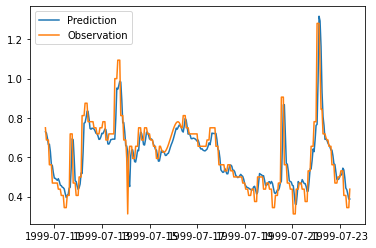

In [180]:
import matplotlib.pyplot as plt
plt.plot(train_results['Date'],train_results['Multivariate'], label ='Prediction')
plt.plot(train_results['Date'],train_results['Actuals'], label='Observation')
plt.legend(loc='best')

In [181]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_results['Date'], y=train_results['Multivariate'],
                    mode='lines',
                    name='Fitting Data Training'))
fig.add_trace(go.Scatter(x=train_results['Date'], y=train_results['Actuals'],
                    mode='lines',
                    name='Observation'))

# Edit the layout
fig.update_layout( xaxis_title='<b>Date</b>',
                   yaxis_title='<b><i>Hs</i> [m]</b>')


In [182]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Multivariate':val_predictions, 'Actuals':y_val1})
val_results.head()

2/2 [==============================] - 0s 7ms/step


,Multivariate,Actuals
0,0.416346,0.438
1,0.456977,0.438
2,0.458479,0.375
3,0.434825,0.375
4,0.406750,0.375


In [183]:
val_results['Date'] = data2['Date'].iloc[round(len(reframed)*0.7):round(len(reframed)*0.8)].values
val_results.head()

,Multivariate,Actuals,Date
0,0.416346,0.438,1999-07-23 11:00:00
1,0.456977,0.438,1999-07-23 12:00:00
2,0.458479,0.375,1999-07-23 13:00:00
3,0.434825,0.375,1999-07-23 14:00:00
4,0.406750,0.375,1999-07-23 15:00:00


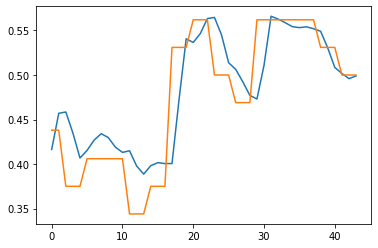

In [184]:
plt.plot(val_results['Multivariate'][:100])
plt.plot(val_results['Actuals'][:100])

In [185]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = go.Figure()
fig.add_trace(go.Scatter(x=val_results['Date'], y=val_results['Multivariate'],
                    mode='lines',
                    name='Fitting Data Validation'))
fig.add_trace(go.Scatter(x=val_results['Date'], y=val_results['Actuals'],
                    mode='lines',
                    name='Observation'))

# Edit the layout
fig.update_layout( xaxis_title='<b>Date</b>',
                   yaxis_title='<b><i>Hs</i> [m]</b>')


In [186]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Multivariate':test_predictions, 'Actuals':y_test1})
test_results.head()

3/3 [==============================] - 0s 6ms/step


,Multivariate,Actuals
0,0.506539,0.562
1,0.534663,0.562
2,0.562513,0.562
3,0.557101,0.656
4,0.593091,0.656


In [187]:
test_results['Date'] = data2['Date'].iloc[round(len(reframed)*0.8):round(len(reframed))].values
test_results.head()

,Multivariate,Actuals,Date
0,0.506539,0.562,1999-07-25 07:00:00
1,0.534663,0.562,1999-07-25 08:00:00
2,0.562513,0.562,1999-07-25 09:00:00
3,0.557101,0.656,1999-07-25 10:00:00
4,0.593091,0.656,1999-07-25 11:00:00


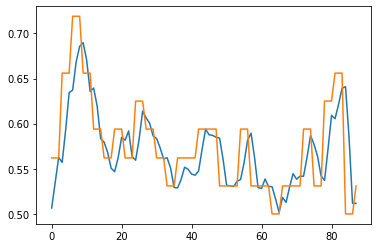

In [188]:
plt.plot(test_results['Multivariate'])
plt.plot(test_results['Actuals'])

In [189]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_results['Date'], y=test_results['Multivariate'],
                    mode='lines',
                    name='Fitting Data Testing'))
fig.add_trace(go.Scatter(x=test_results['Date'], y=test_results['Actuals'],
                    mode='lines',
                    name='Observation'))

# Edit the layout
fig.update_layout( xaxis_title='<b>Date</b>',
                   yaxis_title='<b><i>Hs</i> [m]</b>')


In [190]:
from sklearn.metrics import mean_squared_error
import math

MSE = mean_squared_error(test_results['Actuals'],test_results['Multivariate'])
RMSE = math.sqrt(MSE)
RMSE

0.0363484469352867

In [191]:

from scipy.stats import pearsonr
corr, _ = pearsonr(test_results['Actuals'],test_results['Multivariate'])
corr

0.7164757896488958

In [192]:
# bias 
gap_sum = 0
for j in range(len(test_results['Actuals'])):
  gap = test_results['Multivariate'][j] - test_results['Actuals'][j]
  gap_sum += gap

bias = gap_sum/len(test_results['Actuals'])
bias

-0.005928953940218145

In [193]:
train_results.to_csv('/content/drive/MyDrive/TA (1)/Learn to Code ML/Hasil Prediksi /multivariate_train_lstm_belawan.csv')
val_results.to_csv('/content/drive/MyDrive/TA (1)/Learn to Code ML/Hasil Prediksi /multivariate_val_lstm_belawan.csv')
test_results.to_csv('/content/drive/MyDrive/TA (1)/Learn to Code ML/Hasil Prediksi /multivariate_test_lstm_belawan.csv')

In [194]:
# serialize weights to HDF5
model1.save_weights("/content/drive/MyDrive/TA (1)/Learn to Code ML/Model/model_multivariate_belawan.h5")
print("Model Saved !")

Model Saved !
